<a href="https://colab.research.google.com/github/lsh4205/Traffic_Simulation/blob/main/traffic_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print("Python version:", sys.version)

Python version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


# Define logical 1-D domains #

The following class is a small wrapper around a 1-D Numpy array of values that define a discretized domain with a uniform step size.

In [2]:
class Domain1D:
    def __init__(self, step, min_val=-1, max_val=1):
        from numpy import linspace
        self.step = step
        n = int((max_val - min_val) / step) + 1
        self.vals = linspace(min_val, max_val, n)
        
    def __len__(self): # length in terms of # of grid points
        return len(self.vals)
    
    def __getitem__(self, I): # values by an arbitrary Numpy index-slice `I`
        return self.vals[I]

**Define a discrete time domain: $t \in [0, 120]$ with step size 0.1.**

In [3]:
T = Domain1D(0.1, min_val=0.0, max_val=120.0)
T[:]

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.198e+02, 1.199e+02,
       1.200e+02])

**Define a discrete spatial domain: $x \in [-5, 5]$ with step size 0.01\**.

In [4]:
X = Domain1D(0.01, min_val=-5.0, max_val=5.0)
X[:]

array([-5.  , -4.99, -4.98, ...,  4.98,  4.99,  5.  ])

# Define a "solution grid" #

The following class implements a wrapper around a 2-D Numpy array that can be used to hold $u_{j, i} = u(x_i, t_j)$.

> The indices of $u_{j,i}$ are transposed relative to the "whiteboard" notes.

When instantiated, a `Solution1D` object includes "padding" in space to hold "ghost zones," which are copies of the endpoints that can help simplify how boundary conditions are handled.

In particular, suppose the desired solution domain at discrete time-index $j$ _logically_ consists of the $n$ points $u_{j,0}, u_{j,1}, u_{j,2}, \ldots, u_{j,n-1}$. The `Solution1D` object creates a _physical_ array of size $n+2$, which has extra cells to the left and right of the logical values, as shown below.

$$\begin{array}{r|c|l}
  a_j & u_{j,0} \: u_{j,1} \: \cdots \: u_{j, n-1} & b_j
\end{array}$$

The entries $a_j$ and $b_j$ are the **ghost values**. The function `Solution1D.update_ghosts(j)` will set $a_j \leftarrow u_{j,n-1}$ and $b \leftarrow u_{j,0}$, which correspond to **periodic** or **wraparound** boundary conditions.

In [5]:
class Solution1D: # with periodic "ghost boundaries"
    def __init__(self, T, X, u0=None):
        from numpy import zeros
        assert isinstance(T, Domain1D) and isinstance(X, Domain1D)
        self.T = T
        self.X = X
        self.vals = zeros((len(T), len(X) + 2)) # ghost cells
        
        if u0 is not None and len(T) > 0:
            self.vals[0, 1:-1] = u0(X) if callable(u0) else u0
            self.update_ghosts(0)
            
    def __getitem__(self, s): # values by arbitrary Numpy-style slice
        assert isinstance(s, tuple) and len(s) == 2
        J, I = s[0], s[1]
        return self.vals[J, I]
    
    def __setitem__(self, s, x):
        assert isinstance(s, tuple) and len(s) == 2
        J, I = s[0], s[1]
        self.vals[J, I] = x
        
    def __len__(self):
        return len(self.T)
    
    def update_ghosts(self, j): # periodic boundaries
        self.vals[j+1, 0] = self.vals[j, -2]
        self.vals[j+1, -1] = self.vals[j, 1]

**Helper function: visualizer.** The next function will plot the values of a `Solution1D` object `U` at the time points specified by `J`.

In [8]:
def plot_grid(U, J=[0]
              , figsize=(12, 6.75), markersize=4, linewidth=1
              , title_str=None, axes=True
             ):
    assert isinstance(U, Solution1D)
    
    from matplotlib.pyplot import figure, gca, plot, legend, show
    fig = figure(figsize=figsize)
    ax = gca()

    for c, j in enumerate(J):
        ax.plot(U.X, U[j, 1:-1], 'o-', color=f'C{c}', label=f't={U.T[j]}'
                , markersize=markersize, linewidth=linewidth)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\approx u(x,t)$', rotation=0, horizontalalignment='right')
    if title_str is not None:
        ax.set_title(title_str, loc='left')
    if axes:
        ax.axhline(0, color='grey', linewidth=0.5, linestyle='dashed')
        ax.axvline(0, color='grey', linewidth=0.5, linestyle='dashed')
    legend()
    show()

# Initial conditions #

The following helper functions implement different initial conditions over a domain `X`.

In [9]:
def impulse(X, x0=0.0, w=0.5):
    """A rectangular impulse of height 1.0 centered at `x0` with width `2*w`."""
    assert isinstance(X, Domain1D)
    from numpy import zeros
    u0 = zeros(len(X))
    I1 = (-5 <= X.vals) & (X.vals < -0.25)
    I2 = (-0.25 <= X.vals) & (X.vals < 0)
    I3 = (0 <= X.vals) & (X.vals <= 5)
    u0[I1] = 80.0
    u0[I2] = 160.0
    u0[I3] = 0
    return u0

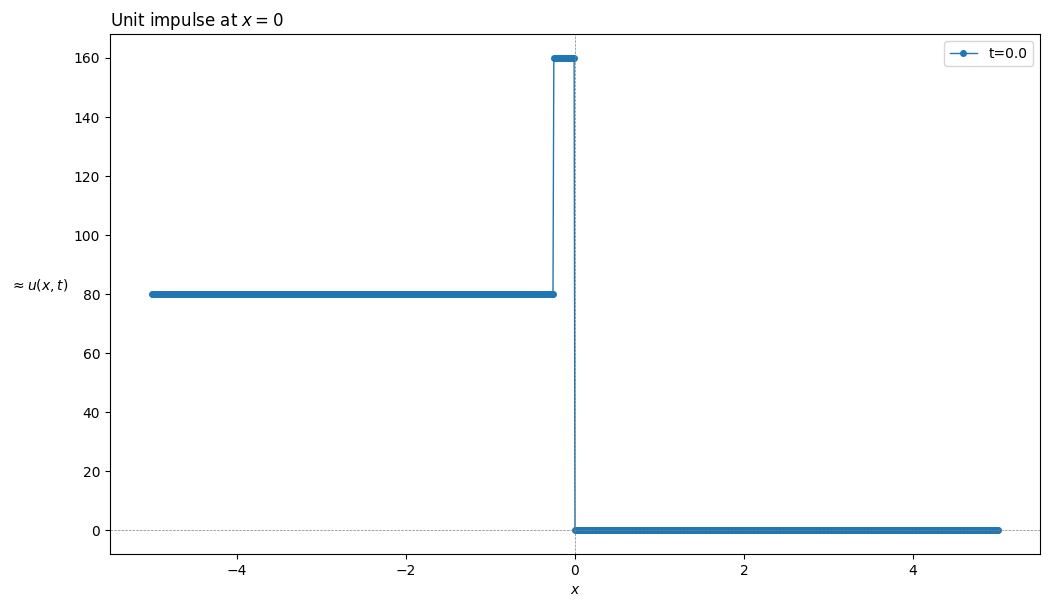

In [10]:
# Demo:
U_impulse = Solution1D(T, X, u0=impulse)
plot_grid(U_impulse, title_str=r'Unit impulse at $x=0$')

> An initial shock. Suppose the maximum density $ρ_{max}$ is 160 cars per km. Traffic enters from the left ($x=−5$ km) at 80 cars per km, half the maximum density. This density is fixed until $x=−0.25$ km, where a “shock” occurs, meaning traffic suddently hits the maximum density. This shock extends until $x=0$ km. To the right of that point, the density is zero.

# Simulator #

Generically, a numerical method takes a `Solution1D` grid as input with some initial condition at `U[0, :]`, and repeatedly runs an update step (`stepper`) to compute the grid at the next time point `U[j+1, :]` from the earlier one at `U[j, :]`.

In [11]:
def simulate(U, stepper): # modifies `U` in-place
    for j in range(0, len(U)-1):
        stepper(U, j)
        U.update_ghosts(j)

In [12]:
def flows(p, dt, dx):
    v_max = 120 / (60 * 60)
    rho_max = 160
    return v_max * p * (1 - p / rho_max)

# 1. PDE-Based Model




• $ρ = ρ(x, t)$ be the density of cars at position $x$ and time $t$, having
units of, say, number of vehicles per $km$;

• $v = v(x, t)$ be the velocity of a car at position $x$ and time $t$, in units
of $km/h$.

• $f = f(x, t)$ be the flow of cars at position x and time t, in units of number of vehicles per hour.

These are interrelated by $f = ρv$, which is consistent with the units.

Suppose the initial conditions $ρ(x, 0) ≡ ρ_0(x)$, $v(x, 0) ≡ v_0(x)$ are given. Furthermore, assume that vehicles cannot travel faster than
$v_{max}$ , and that maximum density of vehicles at any point on the road is $ρ_{max}$ .

The general LWR model says the state of the system evolves in 5 The maximum density would be
related to, say, the typical length of a
vehicle, which determines the largest
number of vehicles that can occupy a
region of space.
time and space according to the partial differential equation (PDE),

\begin{align}
\frac{∂ρ}{∂t}= −\frac{∂f}{∂x}
\end{align}


We make two additional simplifying assumptions. First, we assume that the flow $f$ is an explicit function of $ρ$ only, i.e., $f = f(ρ)$.
When imposing this assumption on
eq. (1), the resulting model is sometimes called the shallow-water equation or
transport equation, and it is an instance
of a nonlinear hyperbolic PDE.

Second, we assume f has the form of a logistic function,

\begin{align}
f(ρ) = v_{max} \cdot ρ \left( 1 - \frac{ρ}{ρ_{max}} \right)
\end{align}
Substituting eq. (2) into eq. (1) yields

\begin{align}
\frac{∂ρ}{∂t} = − \frac{∂f}{∂x}
\end{align}

\begin{align}
= -\left( \frac{df}{dρ} \right) \frac{∂ρ}{∂x}
\end{align}

\begin{align}
= -\left( \frac{df}{dρ} \right) \frac{∂ρ}{∂x}
\end{align}

\begin{align}
= −v_{max} \left( 1 − 2 \frac{ρ}{ρ_{max}} \right) \frac{∂ρ}{∂x}
\end{align}

> This model is the one we wish to simulate numerically. We will implement and compare two methods in sections 1.1 and 1.2.

##1.1) Upwind-Scheme


In [13]:
def step_upwind(U, j, c):
    dt, dx = U.T.step, U.X.step
    for i in range(0, len(U[j, :]) - 1):
            U[j + 1, i] = U[j,i] - dt/dx \
                        * (flows(U[j, i+1], dt, dx) - flows(U[j, i], dt, dx))
            # Prevent negative densities
            if U[j+1, i] < 0: U[j+1,i] = 0

##1.2) Lax-Friedrichs scheme

In [14]:
def step_lf(U, j, c):
    dt, dx = U.T.step, U.X.step
    for i in range(1, len(U[j, :])-1):
        U[j + 1, i] = 0.5 * (U[j, i+1] + U[j, i-1])\
                     - dt/dx * 0.5 * (flows(U[j, i+1], dt, dx) - flows(U[j,i-1], dt, dx))

## Simulation

In [15]:
def cfl(c, h=None, s=None, U=None):
    if h is None and U is not None:
        h = U.T.step
    if s is None and U is not None:
        s = U.X.step
    assert h is not None and s is not None, \
           f"*** Can't determine time and/or step size (`h`={h}, `s`={s}) ***"
    return c * h / s

In [21]:
def experiment(c, h, s
               , u0=impulse
               , stepper=step_lf
               , x_max=5.0, num_steps=100, t_max=None
              ):
    if t_max is None:
        assert num_steps is not None and num_steps >= 0
        t_max = num_steps * s
    T = Domain1D(h, min_val=0.0, max_val=t_max)
    X = Domain1D(s, min_val=-x_max, max_val=x_max)
    U = Solution1D(T, X, u0=u0)
    simulate(U, lambda U, j: stepper(U, j, c))
    plot_grid(U, J=[0, len(U)-1]
              , title_str=f'CFL={cfl(c, U=U)}; u0={u0.__name__}')

In [17]:
{f.__name__: f for f in [impulse]}

{'impulse': <function __main__.impulse(X, x0=0.0, w=0.5)>}

In [22]:
from ipywidgets import interact, fixed, FloatSlider, Dropdown

interact(experiment
         , c=FloatSlider(min=-1, max=1, step=0.2, value=1.0)
         , h=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
         , s=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
         , u0={'impulse': impulse}
         , stepper={'Lax-Friedrichs': step_lf, 'upwind': step_upwind}
         , x_max=FloatSlider(min=1.0, max=5.0, step=0.1, value=5.0)
         , num_steps=Dropdown(options=[2, 4, 8, 16, 32, 64, 128, 256, 512, 1_024], value=256)
         , t_max=fixed(None)
        )
pass

interactive(children=(FloatSlider(value=1.0, description='c', max=1.0, min=-1.0, step=0.2), Dropdown(descripti…